#Step 1: Import Kaggle Dataset

In [1]:
!pip install wfdb wget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=2a635d6250bed8c411fef8353bc9b6fcf00b8a15dd7e3bd467a3d0f6fcca3774
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
!pip install -q kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [38]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!kaggle datasets download -d bjoernjostein/georgia-12lead-ecg-challenge-database

Dataset URL: https://www.kaggle.com/datasets/bjoernjostein/georgia-12lead-ecg-challenge-database
License(s): CC0-1.0
 96% 464M/483M [00:03<00:00, 127MB/s]
100% 483M/483M [00:03<00:00, 136MB/s]


In [5]:
!kaggle datasets download -d bjoernjostein/st-petersburg-incart-12lead-arrhythmia-database

Dataset URL: https://www.kaggle.com/datasets/bjoernjostein/st-petersburg-incart-12lead-arrhythmia-database
License(s): ODC Attribution License (ODC-By)
 99% 561M/564M [00:05<00:00, 75.0MB/s]
100% 564M/564M [00:05<00:00, 99.5MB/s]


In [6]:
!kaggle datasets download -d bjoernjostein/ptbxl-electrocardiography-database

Dataset URL: https://www.kaggle.com/datasets/bjoernjostein/ptbxl-electrocardiography-database
License(s): ODC Attribution License (ODC-By)
100% 1.35G/1.35G [00:11<00:00, 159MB/s]
100% 1.35G/1.35G [00:11<00:00, 122MB/s]


In [7]:
!kaggle datasets download -d bjoernjostein/ptb-diagnostic-ecg-database

Dataset URL: https://www.kaggle.com/datasets/bjoernjostein/ptb-diagnostic-ecg-database
License(s): CC0-1.0
 99% 881M/890M [00:08<00:00, 121MB/s]
100% 890M/890M [00:08<00:00, 109MB/s]


In [8]:
!kaggle datasets download -d bjoernjostein/china-12lead-ecg-challenge-database

Dataset URL: https://www.kaggle.com/datasets/bjoernjostein/china-12lead-ecg-challenge-database
License(s): CC0-1.0
 95% 387M/406M [00:02<00:00, 233MB/s]
100% 406M/406M [00:02<00:00, 197MB/s]


In [9]:
!kaggle datasets download -d bjoernjostein/china-physiological-signal-challenge-in-2018

Dataset URL: https://www.kaggle.com/datasets/bjoernjostein/china-physiological-signal-challenge-in-2018
License(s): CC0-1.0
 99% 814M/824M [00:08<00:00, 87.9MB/s]
100% 824M/824M [00:08<00:00, 99.1MB/s]


In [10]:
!kaggle datasets download -d bjoernjostein/physionet-challenge-2021-snomed-mappings

Dataset URL: https://www.kaggle.com/datasets/bjoernjostein/physionet-challenge-2021-snomed-mappings
License(s): unknown
  0% 0.00/4.13k [00:00<?, ?B/s]
100% 4.13k/4.13k [00:00<00:00, 13.6MB/s]


In [11]:
!kaggle datasets download -d erarayamorenzomuten/chapmanshaoxing-12lead-ecg-database

Dataset URL: https://www.kaggle.com/datasets/erarayamorenzomuten/chapmanshaoxing-12lead-ecg-database
License(s): Attribution 4.0 International (CC BY 4.0)
 98% 538M/547M [00:04<00:00, 56.1MB/s]
100% 547M/547M [00:04<00:00, 116MB/s] 


In [12]:
!kaggle datasets download -d erarayamorenzomuten/ningbo-first-hospital-12lead-ecg-database

Dataset URL: https://www.kaggle.com/datasets/erarayamorenzomuten/ningbo-first-hospital-12lead-ecg-database
License(s): Attribution 4.0 International (CC BY 4.0)
 99% 1.77G/1.78G [00:16<00:00, 125MB/s]
100% 1.78G/1.78G [00:16<00:00, 114MB/s]


#Step 2: Load Data

In [13]:
import os, zipfile

dir_name = "./"
extension = ".zip"

os.chdir(dir_name) # change directory from working dir to dir with files

for item in os.listdir(dir_name): # loop through items in dir
    if item.endswith(extension): # check for ".zip" extension
        file_name = os.path.abspath(item) # get full path of files
        zip_ref = zipfile.ZipFile(file_name) # create zipfile object
        zip_ref.extractall(dir_name) # extract file to dir
        zip_ref.close() # close file
        os.remove(file_name) # delete zipped file

In [14]:
# Merge china physiol and china physiol extra
import shutil
import os

source = 'Training_2/'
dest1 = 'Training_WFDB/'

files = os.listdir(source)

for f in files:
    shutil.move(source+f, dest1)

In [15]:
shutil.rmtree("./sample_data/")

#Step 3: Packages and Functions

##Loading some packages and defining a function to load data

In [16]:
import os
import numpy as np, sys,os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import wfdb
import tarfile
import wget
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing.sequence import pad_sequences
import math
import warnings
from scipy import signal
import random
import tqdm
import time
from scipy.signal import butter, lfilter
from scipy.signal import find_peaks
from sklearn.metrics import accuracy_score

%load_ext autoreload
%autoreload
%reload_ext autoreload

In [17]:
def load_challenge_data(filename):
    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64)
    new_file = filename.replace('.mat','.hea')
    input_header_file = os.path.join(new_file)
    with open(input_header_file,'r') as f:
        header_data=f.readlines()
    return data, header_data

#Data


The training data in this study contains 43.101 Electrocariographic recordings from 5 different sources.



1. Southeast University, China, including the data from the China Physiological Signal Challenge 2018 (2 datasets from this source)
2. St. Petersburg Institute of Cardiological Technics, St. Petersburg, Russia.
3. The Physikalisch Technische Bundesanstalt, Brunswick, Germany. (2 datasets from this source)
4. Georgia 12-Lead ECG Challenge Database, Emory University, Atlanta, Georgia, USA.
5. Shaoxing and Ningbi Hospital, China

The data is given in the form of native Python waveform-database-format WFDB. The dataset contains two file types:

1. Header files (.hea)
2. Signal files (.mat)

We have ca 88 000 Signal file with a corresponding header file. Each file are named with a patient number starting with A0001 and goes all the way up to A6877


##Import all diagnosis to Notebook

In [18]:
my_dirs = ['WFDB_ChapmanShaoxing',  'Georgia', 'Training_StPetersburg', 'WFDB_Ningbo', 'Training_WFDB', 'Training_PTB']

In [19]:
ecg_filenames = []
for directory in my_dirs:
  current_path = os.path.join("./", directory)
  for ecgfilename in tqdm.tqdm(sorted(os.listdir(current_path))):
      if ecgfilename.endswith(".mat"):
          ecg_filenames.append(os.path.join(current_path, ecgfilename))


100%|██████████| 1032/1032 [00:00<00:00, 912997.62it/s]


In [20]:
len(ecg_filenames)

66416

In [21]:
def load_header(header_file):
    with open(header_file, 'r') as f:
        header = f.read()
    return header

def get_labels(header):
    labels = list()
    for l in header.split('\n'):
        if l.startswith('#Dx'):
            try:
                entries = l.split(': ')[1].split(',')
                for entry in entries:
                    labels.append(entry.strip())
            except:
                pass
    return labels

def is_integer(x):
    if is_number(x):
        return float(x).is_integer()
    else:
        return False

def is_number(x):
  try:
      float(x)
      return True
  except (ValueError, TypeError):
      return False

In [22]:
classes = set()
for ecg_file in tqdm.tqdm(ecg_filenames):
  header_file = ecg_file.replace('.mat','.hea')
  header = load_header(header_file)
  classes |= set(get_labels(header))
if all(is_integer(x) for x in classes):
    classes = sorted(classes, key=lambda x: int(x)) # Sort classes numerically if numbers.
else:
    classes = sorted(classes) # Sort classes alphanumerically if not numbers.
num_classes = len(classes)

100%|██████████| 66416/66416 [00:01<00:00, 40441.93it/s]


In [23]:
num_classes

131

In [24]:
SNOMED_scored=pd.read_csv("dx_mapping_scored.csv", sep=",")
lab_arr = np.asarray(SNOMED_scored['SNOMEDCTCode'], dtype="str")
scored_classes = []
for i in classes:
  for j in lab_arr:
    if i == '':
      continue
    if i == j:
      scored_classes.append(i)
scored_classes = sorted(scored_classes)

In [25]:
len(scored_classes)

30

In [26]:
def get_labels_internal(header):
    labels = list()
    for l in header:
        if l.startswith('#Dx'):
            try:
                entries = l.split(': ')[1].split(',')
                for entry in entries:
                    labels.append(entry.strip())
            except:
                pass
    return labels

In [27]:
def get_scored_ohe_labels(diagnoses, scored_classes):
  num_classes = len(scored_classes)
  labels = np.zeros(num_classes)
  for diagnose in diagnoses:
    if diagnose in scored_classes:
      j = scored_classes.index(diagnose)
      labels[j] = 1
  return labels

In [28]:
def pad_and_resample(ecg_data, header_data, new_fs = 100):
  current_len = int(header_data[0].split(" ")[3])
  current_fs = int(header_data[0].split(" ")[2])
  if current_len//current_fs != 10:
    ecg_padded = pad_sequences(ecg_data, maxlen=int(current_fs * 10), truncating='post',padding="post")
  else:
    ecg_padded = ecg_data

  if current_fs != new_fs:
    rsmp_ecg = signal.resample(ecg_padded, 10 *new_fs, axis = 1)
  else:
    rsmp_ecg = ecg_padded

  return np.moveaxis(rsmp_ecg, 1, -1)

In [29]:
def resample_and_pad(ecg_data, header_data, new_fs = 100):
  if int(header_data[0].split(" ")[2]) != new_fs:
    rsmp_ecg = signal.resample(ecg_data, int((int(header_data[0].split(" ")[3])/int(header_data[0].split(" ")[2]))*new_fs))
  else:
    rsmp_ecg = ecg_data

  if rsmp_ecg.shape[1] != int(new_fs * 10):
    ecg_padded = pad_sequences(rsmp_ecg, maxlen=int(new_fs * 10), truncating='post',padding="post")
  else:
    ecg_padded = rsmp_ecg
  return np.moveaxis(ecg_padded, 1, -1)

In [43]:
def label_data_and_save_npy(path, scored_classes, dest_path, name):
  label_list = []
  ecg_list = []
  for ecgfilename in tqdm.tqdm(sorted(os.listdir(path))):
    if ecgfilename.endswith(".mat"):
      data, header_data = load_challenge_data(path + ecgfilename)
      processed_data = pad_and_resample(data, header_data)
      temp_labels = get_labels_internal(header_data)
      labels = get_scored_ohe_labels(temp_labels, scored_classes)
      label_list.append(labels)
      ecg_list.append(processed_data)
  label_list = np.asarray(label_list)
  ecg_list = np.asarray(ecg_list)
  np.save(os.path.join(dest_path, "X_data_" + name), ecg_list)
  np.save(os.path.join(dest_path, "y_data_" + name), label_list)


In [44]:
dest_path = '../../content/drive/MyDrive/fdl_ecg_data/'

In [42]:
os.mkdir(dest_path)

In [45]:
label_data_and_save_npy("/content/WFDB_Ningbo/", scored_classes, dest_path, "ningbo")

100%|██████████| 69810/69810 [00:30<00:00, 2262.75it/s]


In [46]:
label_data_and_save_npy("/content/WFDB_ChapmanShaoxing/", scored_classes, dest_path,"chapman")

100%|██████████| 20494/20494 [00:28<00:00, 723.80it/s]


In [47]:
label_data_and_save_npy("/content/Georgia/", scored_classes, dest_path, "georgia")

100%|██████████| 20688/20688 [00:13<00:00, 1520.06it/s]


In [48]:
label_data_and_save_npy("/content/WFDB/", scored_classes, dest_path, "ptbxl")

100%|██████████| 43674/43674 [00:38<00:00, 1148.86it/s]


In [49]:
label_data_and_save_npy("/content/Training_StPetersburg/", scored_classes, dest_path, "stpeter")

100%|██████████| 148/148 [00:05<00:00, 28.07it/s]


In [50]:
label_data_and_save_npy("/content/Training_WFDB/", scored_classes, dest_path, "chinaphys")

100%|██████████| 20660/20660 [00:25<00:00, 819.84it/s] 


In [51]:
label_data_and_save_npy("/content/Training_PTB/", scored_classes, dest_path, "ptbdiag")

100%|██████████| 1032/1032 [00:08<00:00, 117.15it/s]


In [73]:
test_data = np.load("/content/y_data_ningbo.npy")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

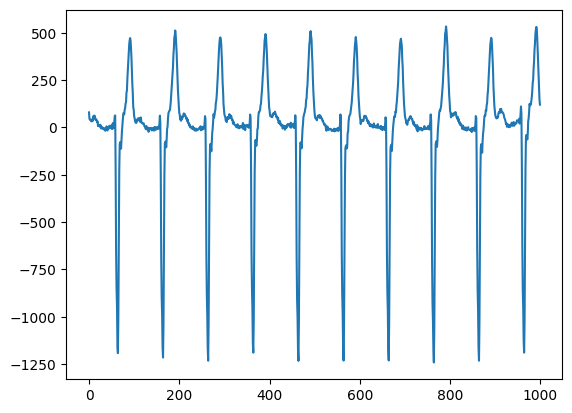

In [43]:
plt.plot(test_data[4,1,:])

In [ ]:
def import_key_data(path):
  gender=[]
  age=[]
  labels=[]
  ecg_filenames=[]
  for ecgfilename in tqdm.tqdm(sorted(os.listdir(path))):
      if ecgfilename.endswith(".mat"):
          data, header_data = load_challenge_data(path + ecgfilename)
          labels.append(header_data[15][5:-1])
          ecg_filenames.append(path + ecgfilename)
          gender.append(header_data[14][6:-1])
          age.append(header_data[13][6:-1])
  return gender, age, labels, ecg_filenames

gender_temp, age_temp, labels_temp, ecg_filenames = import_key_data()
ecg_filenames = np.asarray(ecg_filenames)

100%|██████████| 176506/176506 [02:06<00:00, 1395.49it/s]


From the figure under we can se that the signals varies, but most of the signals are around 5000 samples long

From the header file we have access to gender and age from each patient

In [ ]:
def clean_gender_data(gender):
  gender = np.asarray(gender)
  gender[np.where(gender == "Male")] = 0
  gender[np.where(gender == "male")] = 0
  gender[np.where(gender == "M")] = 0
  gender[np.where(gender == "Female")] = 1
  gender[np.where(gender == "female")] = 1
  gender[np.where(gender == "F")] = 1
  gender[np.where(gender == "NaN")] = 2
  gender[np.where(gender == "Unknown")] = 2
  np.unique(gender)
  gender = gender.astype(np.int)
  return gender
gender_temp_binary = clean_gender_data(gender_temp)
gender_temp_binary.shape

(88253,)

In [ ]:
def clean_age_data(age):
  age = np.asarray(age)
  age[np.where(age == "NaN")] = -1
  np.unique(age)
  age = age.astype(np.int)
  return age
age_temp_clean = clean_age_data(age_temp)
age_temp_clean.shape

(88253,)

# Visualize data

In [ ]:
def abbrev(snomed_classes):
  SNOMED_scored = pd.read_csv("/content/dx_mapping_scored.csv", sep=",")
  snomed_abbr = []
  for j in range(len(snomed_classes)):
      for i in range(len(SNOMED_scored.iloc[:,1])):
          if (str(SNOMED_scored.iloc[:,1][i]) == snomed_classes[j]):
              snomed_abbr.append(SNOMED_scored.iloc[:,0][i])

  snomed_abbr = np.asarray(snomed_abbr)
  return snomed_abbr

In [ ]:
abbr = abbrev(scored_classes)